### Langgraph  Human In the Loop

Review
For human-in-the-loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

Goals

Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

In [2]:
from dotenv import load_dotenv
load_dotenv()
import os

# from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI


os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


# llm=ChatGroq(model="qwen-2.5-32b")
llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BRkEe4TlImhtqaWdCGycp5IZzT9Wu', 'finish_reason': 'stop', 'logprobs': None}, id='run-edf44a89-32b7-4566-9016-76314fb8881c-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools=llm.bind_tools(tools)

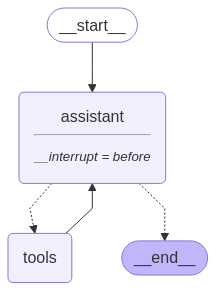

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
## human in the loop
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
initial_input={"messages":HumanMessage(content="Multiply 5 and 3")}

thread={"configurable":{"thread_id":"1"}}



In [6]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3


In [7]:
state=graph.get_state(thread)
state.next

('assistant',)

In [8]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='8605d4ff-a348-45c2-b5f0-e9e5aaf871e6')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0252a0-5147-612a-8000-9d097e3023cd'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-29T18:44:45.256521+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0252a0-5143-6a66-bfff-c5864e902909'}}, tasks=(PregelTask(id='31c879fb-78bd-3c69-6b76-ed79e4924017', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [9]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_iwIPoHhMoFz33axVNR7U2kNt)
 Call ID: call_iwIPoHhMoFz33axVNR7U2kNt
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15


In [10]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()


================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


# Edit with Human feedback

In [11]:
initial_input={"messages":HumanMessage(content="Multiply 5 and 3")}

thread={"configurable":{"thread_id":"2"}}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3


In [12]:
graph.update_state(thread,{"messages":[HumanMessage(content="No, actually add 15 and 5!")]})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0252a0-5fa1-6cfc-8001-2fb0189cad40'}}

In [13]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================ Human Message =================================

No, actually add 15 and 5!


In [14]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually add 15 and 5!
================================== Ai Message ==================================
Tool Calls:
  add (call_vNAJgmz854lssGgdKdR5VHwP)
 Call ID: call_vNAJgmz854lssGgdKdR5VHwP
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: add

20


In [15]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================ Human Message =================================

No, actually add 15 and 5!
================================== Ai Message ==================================
Tool Calls:
  add (call_vNAJgmz854lssGgdKdR5VHwP)
 Call ID: call_vNAJgmz854lssGgdKdR5VHwP
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: add

20


# Wait for user input

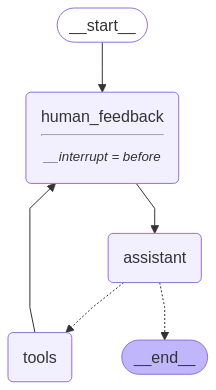

In [16]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
# Input
initial_input = {"messages": "Multiply 5 and 3"}

# Thread
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


## get user input

user_input=input("Tell me how you want to update the state:")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================ Human Message =================================

mutiply 10 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_bGi5sddxDBekjSUYNbPoWQ85)
 Call ID: call_bGi5sddxDBekjSUYNbPoWQ85
  Args:
    a: 5
    b: 3
  multiply (call_Em8oaW96RImLmPDi2dgAe8Lx)
 Call ID: call_Em8oaW96RImLmPDi2dgAe8Lx
  Args:
    a: 10
    b: 3
================================= Tool Message =================================
Name: multiply

30


In [19]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15, and the result of multiplying 10 and 3 is 30.
